### Clase ProcesarVideo
---

In [1]:
import face_recognition
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from PIL import Image
from datetime import datetime, timedelta
import time

In [2]:
start = time.time()

In [3]:
class ProcesarVideo:
    def __init__(self, basePath='.', videoFileName=None, fyh=None, fuente=None):
        self.basePath = basePath
        self.fileName = basePath + '/canales/' + fuente + '/' + videoFileName
        self.path_ddbb = basePath + '/ddbb'
        self.path_indentificadas = basePath + '/img/indentificadas'
        self.path_no_indentificadas = basePath + '/img/no_indentificadas'
        #self.fechaYhora = datetime.strptime(fyh, '%d/%m/%Y %H:%M:%S')
        self.fechaYhora = datetime.strptime(fyh, '%Y-%m-%d-%H-%M-%S')
        self.fuente=fuente
        self.mostrarVideo = False
        self.generoPorPersonaje={}
        self.videoFileName = videoFileName
        
    def __inicializar(self):
        self.genderProto = self.basePath + '/model/gender_deploy.prototxt'
        self.genderModel = self.basePath + '/model/gender_net.caffemodel'
        self.genderNet = cv2.dnn.readNet(self.genderProto, self.genderModel)
        self.genderList = ['M', 'F']
        self.MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
        
#         print('   basePath', self.basePath)
#         print('   videoFileName', self.fileName)
#         print('   path_ddbb', self.path_ddbb)
#         print('   path_indentificadas', self.path_indentificadas)
#         print('   path_no_indentificadas', self.path_no_indentificadas)
#         print('   genderProto', self.genderProto)
#         print('   genderModel', self.genderModel)

    def __convertToRGB(self, image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def __saveImage(self, path, fechaYhora, sz, image):
        pil_image = Image.fromarray(image)
        file = path +'/'+ fechaYhora + '_'+ sz +'.png'
        pil_image.save(file)

    def __cargarBaseDeDatos(self):
        faces = os.listdir(self.path_ddbb)

        self.encodings = []
        self.nombres = []
        
        for face in faces:
            fileName = self.path_ddbb +'/'+ face
            image = face_recognition.load_image_file(fileName)
            encoding = face_recognition.face_encodings(image)[0]
            nombre = os.path.splitext(face)[0]
            
            self.encodings.append(encoding)
            self.nombres.append(nombre)
            
            #Obtiene el genero de los personajes de la base de datos
            blob = cv2.dnn.blobFromImage(image, 1.0, (227, 227), self.MODEL_MEAN_VALUES, swapRB=False)
            self.genderNet.setInput(blob)
            genderPreds = self.genderNet.forward()
            genero = self.genderList[genderPreds[0].argmax()]
            self.generoPorPersonaje[nombre] = genero        
            #print('   ', nombre, genero)           
        print('  personajes', len(self.nombres))
        
    def __detectarGenero(self, nombre, image):
        genero = None
        if nombre is None:
            blob = cv2.dnn.blobFromImage(image, 1.0, (227, 227), self.MODEL_MEAN_VALUES, swapRB=False)
            self.genderNet.setInput(blob)
            genderPreds = self.genderNet.forward()
            genero = self.genderList[genderPreds[0].argmax()]
        else:  
            genero = self.generoPorPersonaje.get(nombre)
        return(genero)
            
    def __faceRecognition(self, image, fechaYhora):
        personaje = self.diccionario['personaje']
        fecha_hora = self.diccionario['fecha_hora']
        genero = self.diccionario['genero']

        faceLocations = face_recognition.face_locations(image)

        if len(faceLocations) > 0:
            for faceLocation in faceLocations:

                top, right, bottom, left = faceLocation

                #Marco ampliado
                marginW = int((right - left) * 0.25)
                marginT = int((bottom - top) * 0.5)
                marginB = int((bottom - top) * 0.25)

                faceImage = image[top-marginT:bottom+marginB, left-marginW:right+marginW]

                fecha_hora.append(fechaYhora)

                indiceNoEncontrado = 0

                if(len(self.encodings) > 0):
                    
                    fe = face_recognition.face_encodings(faceImage)
                    if len(fe) > 0:
                        faceEncode = fe[0]

                        matches = face_recognition.compare_faces(self.encodings, faceEncode)

                        face_distances = face_recognition.face_distance(self.encodings, faceEncode)
                        best_match_index = np.argmin(face_distances)

                        if matches[best_match_index]:
                            name = self.nombres[best_match_index]
                            personaje.append(name)
                            genero.append(self.__detectarGenero(name, faceImage))
                            #self.__saveImage(self.path_indentificadas, fechaYhora.strftime("%Y%d%m_%H%M%S"), name, self.__convertToRGB(faceImage))
                        else:
                            personaje.append('NO IDENTIFICADO')
                            self.__saveImage(self.path_no_indentificadas, fechaYhora.strftime("%Y%d%m_%H%M%S"), str(indiceNoEncontrado), self.__convertToRGB(faceImage))
                            indiceNoEncontrado += 1
                            genero.append(self.__detectarGenero(None, faceImage))
                    else:
                        personaje.append('SIN PERSONAS IDENTIFICABLES')
                        genero.append(None)
                else:
                    personaje.append('NO IDENTIFICADO')
                    self.__saveImage(self.path_no_indentificadas, fechaYhora.strftime("%Y%d%m_%H%M%S"), str(indiceNoEncontrado), self.__convertToRGB(faceImage))
                    indiceNoEncontrado += 1
                    genero.append(self.__detectarGenero('NO IDENTIFICADO', faceImage))
        else:
            fecha_hora.append(fechaYhora)
            personaje.append('SIN PERSONAS IDENTIFICABLES')
            genero.append(None)

        print(f'   {fechaYhora} personas {len(faceLocations)}\r', end="")

        return(faceLocations)
    
    def __enmarcarCaras(self, frame, faceLocations):
        thickness = 2
        for faceLocation in faceLocations:

            top, right, bottom, left = faceLocation

            #Marco ampliado
            marginW = int((right - left) * 0.25)
            marginT = int((bottom - top) * 0.5)
            marginB = int((bottom - top) * 0.25)

            start_point = (left-marginW, top-marginT)
            end_point = (right+marginW, bottom+marginB)
            color = (0, 255, 0) 

            frame = cv2.rectangle(frame, start_point, end_point, color, thickness)

            #Cara  
            start_point = (left, top)
            end_point = (right, bottom)
            color = (255, 0, 0) 

            frame = cv2.rectangle(frame, start_point, end_point, color, thickness)
            
    def __crearDirectorios(self):

        if(not os.path.exists(self.basePath + '/img')):
            os.mkdir(self.basePath + '/img')

        if(not os.path.exists(self.path_indentificadas)):
            os.mkdir(self.path_indentificadas)

        if(not os.path.exists(self.path_no_indentificadas)):
            os.mkdir(self.path_no_indentificadas)
            
        if(not os.path.exists(self.path_ddbb)):
            os.mkdir(self.path_ddbb)

    def __procesar(self):
        agrupamiento = 0

        self.diccionario = {}
        self.diccionario['personaje'] = []
        self.diccionario['fecha_hora'] = []
        self.diccionario['genero'] = []

        videoFile = self.fileName
        print('  videoFile',videoFile)
        
        cap = cv2.VideoCapture(videoFile)
        
        
        
        try:           
            while cap.isOpened():
                
                ret, frame = cap.read()

                #Toma un frame por cada segundo
                if ret == True:
                    faceLocations = self.__faceRecognition(frame, self.fechaYhora)

                    if(self.mostrarVideo):
                        self.__enmarcarCaras(frame, faceLocations)
                        cv2.imshow('Frame', frame)

                    agrupamiento += 1
                    self.fechaYhora += timedelta(seconds=1)

                    #Q = terminar si se esta mostrando el video
                    if cv2.waitKey(25) & 0xFF == ord('q'):
                        break
                else:
                    break
            
        except Exception as e:
            print("Error", e.args)
            
        finally:
            cap.release()
            cv2.destroyAllWindows()
            
    def __crearDF(self):
        df = pd.DataFrame()
        df['personaje'] = pd.Series(self.diccionario['personaje'])
        df['fecha_hora'] = pd.Series(self.diccionario['fecha_hora'])
        df['genero'] = pd.Series(self.diccionario['genero'])
        df['file'] = self.fuente + self.videoFileName
        
        if self.fuente is not None:
            df['fuente'] = self.fuente
            
        return(df)
        
    def transform(self):
        print('inicializar')
        self.__inicializar()

        print('verificando directorios')
        self.__crearDirectorios()
        
        print('cargando base de datos')
        self.__cargarBaseDeDatos()
        
        print('procesando')
        self.__procesar()
        
        print('creando DataFrame')
        df = self.__crearDF()
        return(df)

### Proceso
---
El proceso toma los videos de directorio <b>../Data/Video/canales</b> agrupados por fuente Ej:

<pre>
canales
    TN
        2020-08-06-22-00-00.mp4
        2020-09-06-22-00-00.mp4
    C5N
</pre>

El nombre del archivo debe contener la fecha y hora de captura con el siguiente formato Ej:<br>
<b>yyyy-mm-dd-hh-mi-ss.mp4</b>

### Instalar
`pip install face-recognition`<br>
`pip install opencv-python`

### Ejecutar en Python version <b>3.8.3</b>
`!python --version`

fuente: C5N fyh: 2020-08-18-17-57-53 video: 2020-08-18-17-57-53.mp4
inicializar
verificando directorios
cargando base de datos
  personajes 69
procesando
  videoFile ../Data/Video/canales/C5N/2020-08-18-17-57-53.mp4
creando DataFrame19:03 personas 2


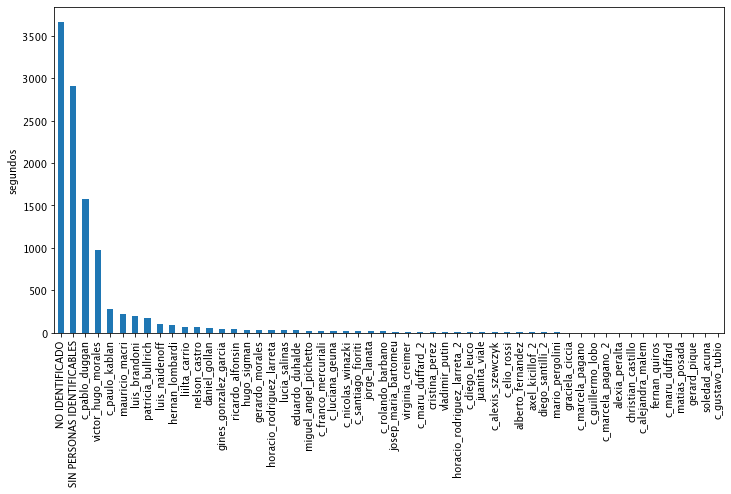

fuente: C5N fyh: 2020-08-15-17-00-45 video: 2020-08-15-17-00-45.mp4
inicializar
verificando directorios
cargando base de datos
  personajes 69
procesando
  videoFile ../Data/Video/canales/C5N/2020-08-15-17-00-45.mp4
creando DataFrame00:43 personas 0


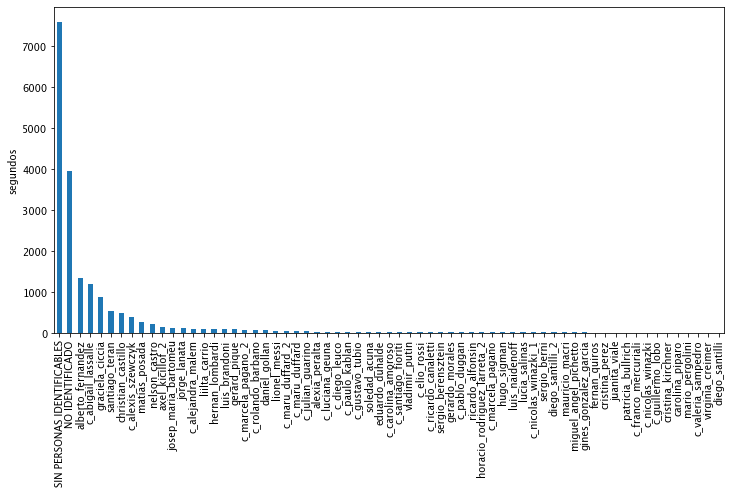

fuente: C5N fyh: 2020-08-17-17-54-34 video: 2020-08-17-17-54-34.mp4
inicializar
verificando directorios
cargando base de datos
  personajes 69
procesando
  videoFile ../Data/Video/canales/C5N/2020-08-17-17-54-34.mp4
creando DataFrame00:46 personas 0


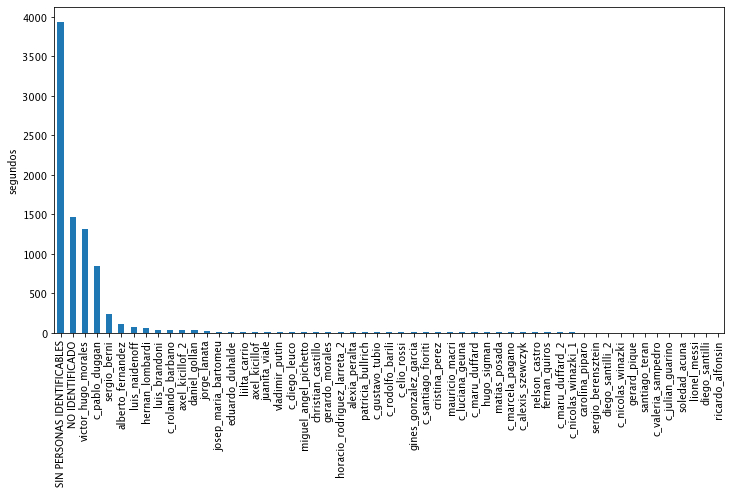

fuente: C5N fyh: 2020-08-25-17-55-42 video: 2020-08-25-17-55-42.mp4
inicializar
verificando directorios
cargando base de datos
  personajes 69
procesando
  videoFile ../Data/Video/canales/C5N/2020-08-25-17-55-42.mp4
creando DataFrame03:00 personas 1


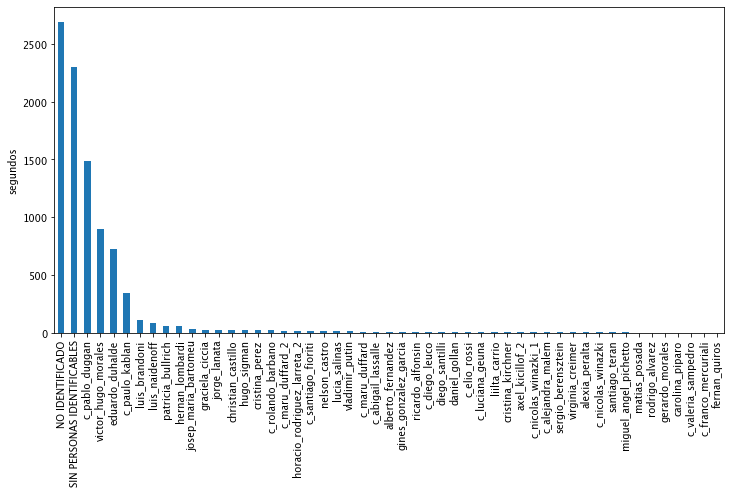

fuente: C5N fyh: 2020-08-14-17-55-49 video: 2020-08-14-17-55-49.mp4
inicializar
verificando directorios
cargando base de datos
  personajes 69
procesando
  videoFile ../Data/Video/canales/C5N/2020-08-14-17-55-49.mp4
creando DataFrame00:46 personas 0


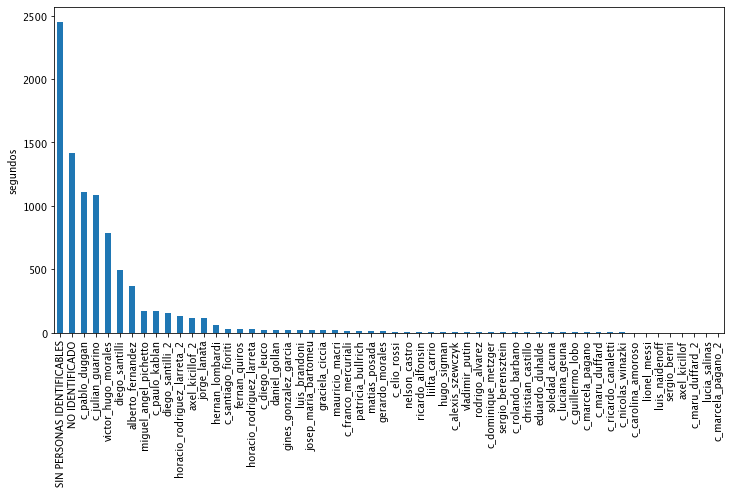

fuente: TN fyh: 2020-08-15-16-30-30 video: 2020-08-15-16-30-30.mp4
inicializar
verificando directorios
cargando base de datos
  personajes 69
procesando
  videoFile ../Data/Video/canales/TN/2020-08-15-16-30-30.mp4
creando DataFrame59:54 personas 1


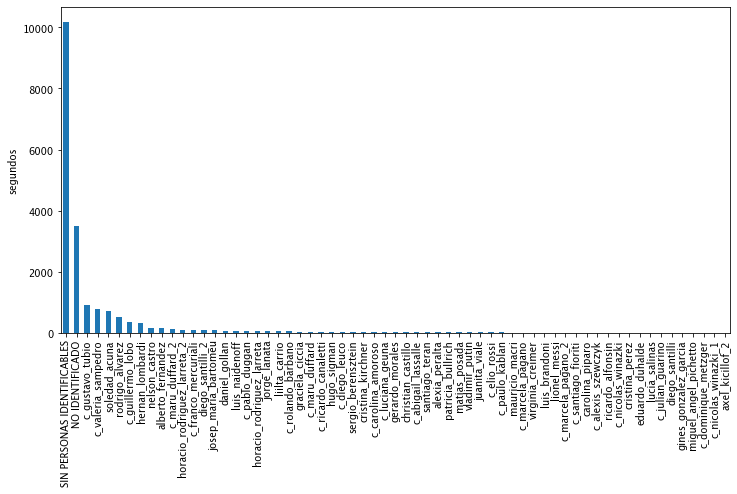

fuente: TN fyh: 2020-08-17-19-00-08 video: 2020-08-17-19-00-08.mp4
inicializar
verificando directorios
cargando base de datos
  personajes 69
procesando
  videoFile ../Data/Video/canales/TN/2020-08-17-19-00-08.mp4
creando DataFrame01:30 personas 0


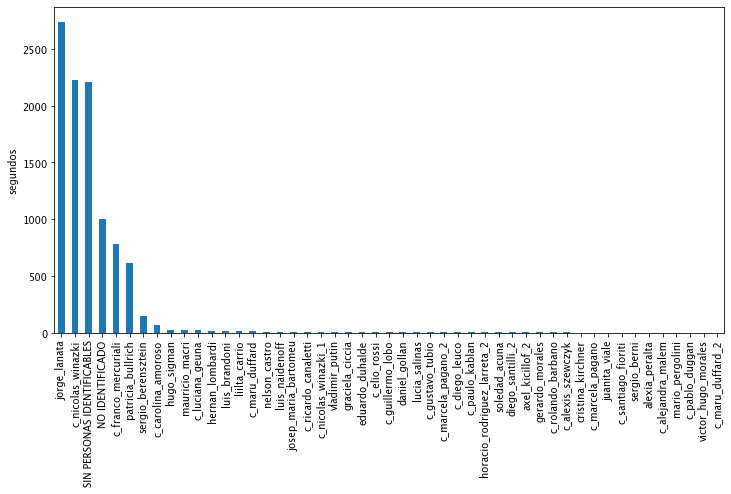

fuente: TN fyh: 2020-08-14-18-59-25 video: 2020-08-14-18-59-25.mp4
inicializar
verificando directorios
cargando base de datos
  personajes 69
procesando
  videoFile ../Data/Video/canales/TN/2020-08-14-18-59-25.mp4
creando DataFrame02:30 personas 1


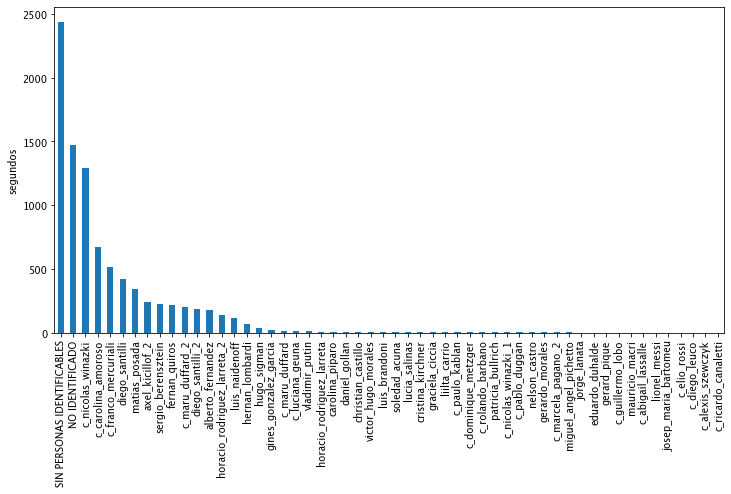

fuente: TN fyh: 2020-08-18-19-00-19 video: 2020-08-18-19-00-19.mp4
inicializar
verificando directorios
cargando base de datos
  personajes 69
procesando
  videoFile ../Data/Video/canales/TN/2020-08-18-19-00-19.mp4
creando DataFrame00:03 personas 02


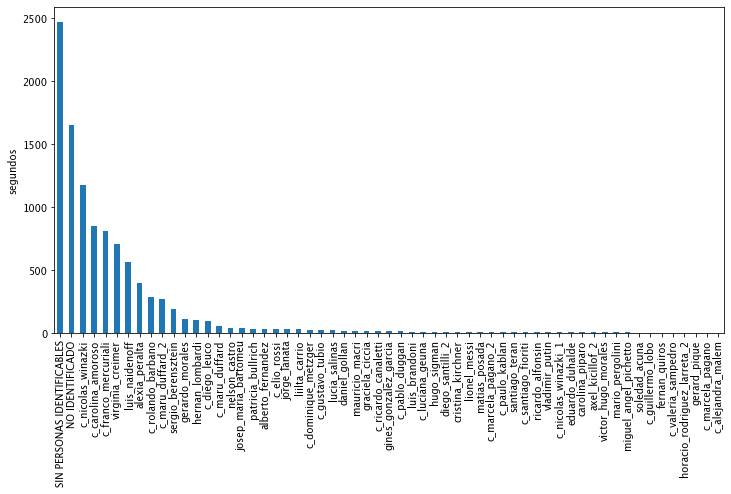

fuente: TN fyh: 2020-08-25-18-59-36 video: 2020-08-25-18-59-36.mp4
inicializar
verificando directorios
cargando base de datos
  personajes 69
procesando
  videoFile ../Data/Video/canales/TN/2020-08-25-18-59-36.mp4


In [ ]:
base = "../Data/Video"
savePath = '..Data/Video/TablasVideo'
dir_videos = base + "/canales"
dataFrames = []

folders_video = listdir(dir_videos)
for fuente in folders_video:
    if not fuente.startswith("."):
        videos = listdir(dir_videos + '/'+ fuente)
        for video in videos:
            if not video.startswith("."):
                fyh = os.path.splitext(video)[0]

                print('fuente:', fuente, 'fyh:', fyh, 'video:', video)
                pv = ProcesarVideo(basePath=base, videoFileName=video, fyh=fyh, fuente=fuente)
                #pv.mostrarVideo=True
                df = pv.transform()
                df.to_csv(base + '/' + fuente + video +'.csv')
                dataFrames.append(df)

                #Graficar resultados
                prob = df.personaje.value_counts()
                prob.plot(kind='bar', figsize=(12,6))
                plt.xticks(rotation=90)
                plt.ylabel('segundos')
                plt.show()

In [ ]:
end = time.time()
print("Tiempo de procesamiento:",round((end - start)/60),"minutos")